In [4]:
%%writefile kaggle.json
{"username":"isaackimani","key":"1746902c1891891e835edc7aa052ddeb"}

Writing kaggle.json


In [1]:
%pip install -q kaggle torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.0/221.0 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 77.4 MB/s eta 0:00:00


In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -qq cell-images-for-detecting-malaria.zip

kaggle.json
Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 88% 597M/675M [00:06<00:01, 55.1MB/s]
100% 675M/675M [00:06<00:00, 105MB/s] 


In [6]:
from torch_snippets import *

In [20]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

In [9]:
from torchvision import transforms as T
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ColorJitter(brightness=(0.95,1.05),
                  contrast=(0.95,1.05),
                  saturation=(0.95,1.05),
                  hue=0.05),
    T.RandomAffine(5, translate=(0.01,0.1)),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5])
])

In [10]:
val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(128),
    T.CenterCrop(128),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5],
                std=[0.5, 0.5, 0.5]),
])

In [11]:
class MalariaImages(Dataset):

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        clss = fname(parent(fpath))
        img = read(fpath, 1)
        return img, clss

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[clss]]) for clss in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = Glob('cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = MalariaImages(trn_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

[10/21/25 05:54:08] INFO     20668                                                                                                     ]8;id=965286;file:///tmp/ipython-input-799725797.py:6\ipython-input-799725797.py]8;;\:]8;id=805265;file:///tmp/ipython-input-799725797.py:6#__init__:6\__init__:6]8;;\

                    INFO     6890                                                                                                      ]8;id=9870;file:///tmp/ipython-input-799725797.py:6\ipython-input-799725797.py]8;;\:]8;id=871180;file:///tmp/ipython-input-799725797.py:6#__init__:6\__init__:6]8;;\

In [13]:
def convBlock(ni, no):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )

class MalariaClassifier(nn.Module):
    def __init__(self):
      super().__init__()
      self.model = nn.Sequential(
          convBlock(3, 64),
          convBlock(64, 64),
          convBlock(64, 128),
          convBlock(128, 256),
          convBlock(256, 512),
          convBlock(512, 64),
          nn.Flatten(),
          nn.Linear(256, 256),
          nn.Dropout(0.2),
          nn.ReLU(inplace=True),
          nn.Linear(256, len(id2int))
      )
      self.loss_fn = nn.CrossEntropyLoss()
    def forward(self, x):
      return self.model(x)

    def compute_metrics(self, preds, targets):
      loss = self.loss_fn(preds, targets)
      acc = (torch.max(preds, 1)[1] == targets).float().mean()
      return loss, acc

In [15]:
def train_batch(model, data, optimizer, criterion):
  model.train()
  ims, labels, _ = data
  _preds = model(ims)
  optimizer.zero_grad()
  loss, acc = criterion(_preds, labels)
  loss.backward()
  optimizer.step()
  return loss.item(), acc.item()

In [17]:
@torch.no_grad()
def validate_batch(model, data, criterion):
  model.eval()
  ims, labels, _ = data
  _preds = model(ims)
  loss, acc = criterion(_preds, labels)
  return loss.item(), acc.item()

In [21]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optmizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 2
log = Report(n_epochs)
for ex in range(n_epochs):
  N = len(trn_dl)
  for bx, data in enumerate(trn_dl):
    loss, acc = train_batch(model, data, optmizer, criterion)
    log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

  N = len(val_dl)
  for bx, data in enumerate(val_dl):
    loss, acc = validate_batch(model, data, criterion)
    log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
  log.report_avgs(ex+1)

EPOCH: 1.000  trn_loss: 0.276  val_loss: 0.174  trn_acc: 0.885  val_acc: 0.951  (2796.24s - 2796.24s remaining)
EPOCH: 2.000  trn_loss: 0.170  val_loss: 0.153  trn_acc: 0.945  val_acc: 0.947  (5271.92s - 0.00s remaining)


In [27]:
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

In [32]:
def im2gradCAM(x):
  model.eval()
  logits = model(x)
  heatmaps = []
  # Pass a dummy input through im2fmap to get the activations
  activations = im2fmap(x)
  print(activations.shape)
  pred = logits.max(-1)[-1]
  # get the model's prediction
  model.zero_grad()
  # compute gradients with respect to model's most confident logit
  logits[0,pred].backward(retain_graph=True)
  # get the gradients at the required feature map location and take the avg gradient 4 every feature map
  pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
  # multiply each activation map with corresponding gradient average
  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pooled_grads[i]
  # take the mean of all weighted activation maps... that has been weighted by avg. grad at each fmap
  heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
  return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [29]:
SZ = 128
import cv2
def upsampleHeatmap(map, img):
  m, M = map.min(), map.max()
  map = 255 * ((map-m) / (M-m))
  map = np.uint8(map)
  map = cv2.resize(map, (SZ, SZ))
  map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
  map = np.uint8(map)
  map = np.uint8(map*0.7 + img*0.3)
  return map

torch.Size([1, 64, 4, 4])


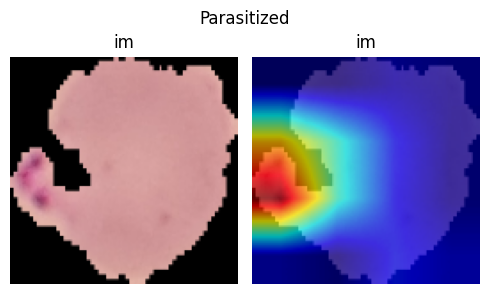

torch.Size([1, 64, 4, 4])


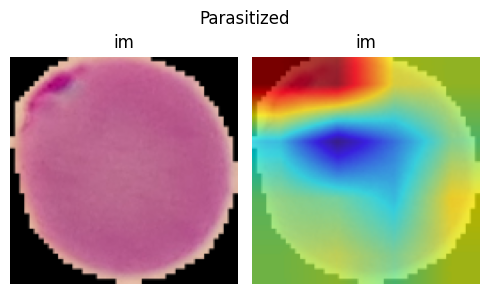

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


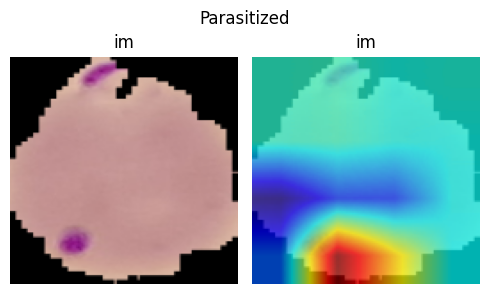

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


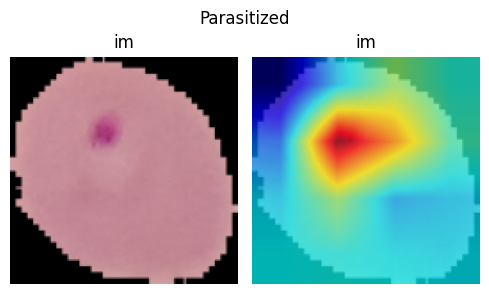

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


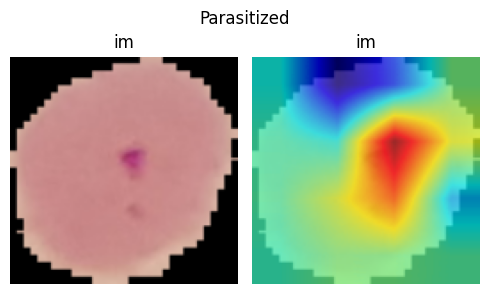

torch.Size([1, 64, 4, 4])


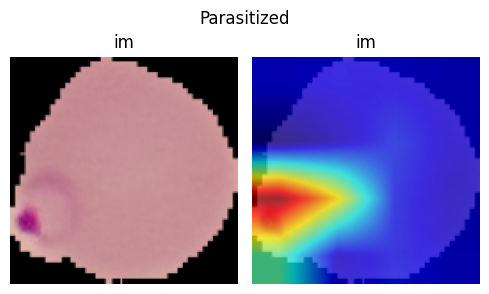

torch.Size([1, 64, 4, 4])


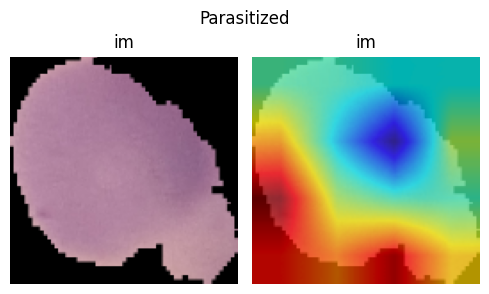

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


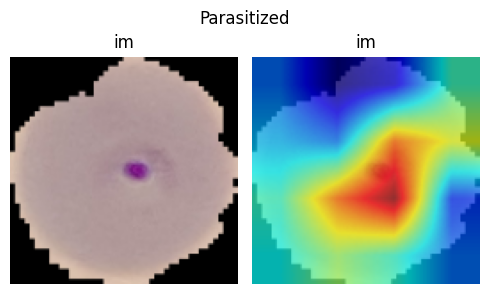

torch.Size([1, 64, 4, 4])


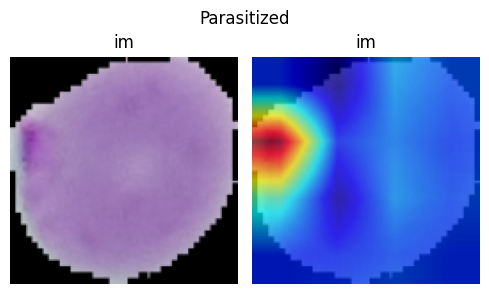

In [35]:
N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x, y, z = next(iter(_val_dl))

for i in range(N):
  image = resize(z[i], SZ)
  heatmap, pred = im2gradCAM(x[i:i+1])
  if(pred=='Uninfected'):
    continue
  heatmap = upsampleHeatmap(heatmap, image)
  subplots([image, heatmap], nc=2, figsize=(5,3), suptitle=pred)